# Topic Modeling on Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=UserWarning)

from bs4 import BeautifulSoup
import gensim
from gensim import corpora
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# visulaization of topic modelling using pyLDAvis library
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()




In [14]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews LIMIT 30000""", con) 
print("Number of data points in our data", filtered_data.shape)




Number of data points in our data (30000, 10)


In [15]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
# Combining all the above stundents 
from tqdm import tqdm_notebook
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm_notebook(filtered_data['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

<input>:9: DeprecationWarning: invalid escape sequence \S
<input>:9: DeprecationWarning: invalid escape sequence \S
<input>:9: DeprecationWarning: invalid escape sequence \S
<ipython-input-18-22bb2614b38f>:9: DeprecationWarning: invalid escape sequence \S
  sentance = re.sub("\S*\d\S*", "", sentance).strip()


In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
STOPWORDS = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean_text(text):
    stop_not = " ".join([i for i in text.lower().split() if i not in STOPWORDS])
    punctuation_free = "".join([i for i in stop_not if i not in exclude])
    normalized = " ".join(lemma.lemmatize(word) for word in punctuation_free.split())
    return normalized

document_cleaned = [clean_text(text).split() for text in preprocessed_reviews] 

In [20]:
filtered_data['CleanedText']=preprocessed_reviews

In [21]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


In [22]:
document_cleaned[:2]

[['bought',
  'several',
  'vitality',
  'canned',
  'dog',
  'food',
  'product',
  'found',
  'good',
  'quality',
  'product',
  'look',
  'like',
  'stew',
  'processed',
  'meat',
  'smell',
  'better',
  'labrador',
  'finicky',
  'appreciates',
  'product',
  'better'],
 ['product',
  'arrived',
  'labeled',
  'jumbo',
  'salted',
  'peanut',
  'peanut',
  'actually',
  'small',
  'sized',
  'unsalted',
  'sure',
  'error',
  'vendor',
  'intended',
  'represent',
  'product',
  'jumbo']]

In [23]:
bigram = gensim.models.Phrases(document_cleaned, min_count=5, threshold=100) 
#trigram = gensim.models.Phrases(bigram[document_cleaned], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# # See trigram example
# print(trigram_mod[bigram_mod[document_cleaned[0]]])

In [24]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_bigrams = make_bigrams(document_cleaned)

In [25]:
data_words_bigrams[:2]

[['bought',
  'several',
  'vitality',
  'canned',
  'dog',
  'food',
  'product',
  'found',
  'good',
  'quality',
  'product',
  'look',
  'like',
  'stew',
  'processed',
  'meat',
  'smell',
  'better',
  'labrador',
  'finicky',
  'appreciates',
  'product',
  'better'],
 ['product',
  'arrived',
  'labeled',
  'jumbo',
  'salted',
  'peanut',
  'peanut',
  'actually',
  'small',
  'sized',
  'unsalted',
  'sure',
  'error',
  'vendor',
  'intended',
  'represent',
  'product',
  'jumbo']]

In [26]:
# Creating the term dictionary of our courpus, 
# where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_words_bigrams)

# Converting list of documents (corpus) 
# into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(text) for text in data_words_bigrams]

In [27]:
doc_term_matrix[:2]

[[(0, 1),
  (1, 2),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 3),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(14, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 2),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1)]]

In [28]:
dictionary[0]

'appreciates'

In [29]:
dictionary[1]

'better'

In [30]:
[[(dictionary[id],freq) for id,freq in crps] for crps in doc_term_matrix[:1]]

[[('appreciates', 1),
  ('better', 2),
  ('bought', 1),
  ('canned', 1),
  ('dog', 1),
  ('finicky', 1),
  ('food', 1),
  ('found', 1),
  ('good', 1),
  ('labrador', 1),
  ('like', 1),
  ('look', 1),
  ('meat', 1),
  ('processed', 1),
  ('product', 3),
  ('quality', 1),
  ('several', 1),
  ('smell', 1),
  ('stew', 1),
  ('vitality', 1)]]

#### LDA: chunksize = 2000, passes = 1, num_topics = 10

In [42]:
# Build the LDA model
from gensim.models import LdaModel
lda_model = LdaModel(corpus=doc_term_matrix,id2word=dictionary,num_topics=10,random_state=100,
                     update_every=1,chunksize=2000,passes=1,alpha='auto',per_word_topics=True)

In [43]:
lda_model.print_topics()

[(0,
  '0.021*"make" + 0.020*"use" + 0.014*"great" + 0.014*"mix" + 0.012*"add" + 0.010*"good" + 0.010*"water" + 0.009*"product" + 0.008*"easy" + 0.008*"packet"'),
 (1,
  '0.026*"great" + 0.022*"price" + 0.018*"amazon" + 0.017*"toy" + 0.016*"product" + 0.015*"get" + 0.014*"good" + 0.011*"order" + 0.009*"love" + 0.009*"shipping"'),
 (2,
  '0.017*"product" + 0.013*"dog" + 0.013*"one" + 0.012*"would" + 0.012*"bag" + 0.011*"amazon" + 0.010*"box" + 0.009*"treat" + 0.008*"like" + 0.008*"time"'),
 (3,
  '0.046*"food" + 0.043*"dog" + 0.020*"cat" + 0.018*"love" + 0.017*"treat" + 0.008*"one" + 0.008*"old" + 0.008*"get" + 0.008*"baby" + 0.007*"day"'),
 (4,
  '0.025*"like" + 0.022*"taste" + 0.020*"chip" + 0.019*"flavor" + 0.014*"popcorn" + 0.013*"good" + 0.012*"great" + 0.012*"love" + 0.009*"best" + 0.009*"one"'),
 (5,
  '0.118*"coffee" + 0.020*"cup" + 0.018*"flavor" + 0.014*"taste" + 0.013*"one" + 0.012*"good" + 0.011*"like" + 0.010*"blend" + 0.009*"strong" + 0.009*"k_cup"'),
 (6,
  '0.010*"oil" +

In [44]:
lda_df = lda_model.get_document_topics(doc_term_matrix,minimum_probability=0)
lda_df = pd.DataFrame(list(lda_df))
num_topics = lda_model.num_topics
lda_df.columns = ['Topic'+str(i) for i in range(num_topics)]
for i in range(len(lda_df.columns)):
    lda_df.iloc[:,i]=lda_df.iloc[:,i].apply(lambda x: x[1])
lda_df['Automated_topic_id'] =lda_df.apply(lambda x: np.argmax(x),axis=1)
lda_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Automated_topic_id
0,0.005079,0.004733,0.228419,0.156089,0.007395,0.003544,0.583196,0.002866,0.003194,0.005485,Topic6
1,0.006404,0.243702,0.007970,0.004860,0.149587,0.004469,0.174412,0.003615,0.168382,0.236600,Topic1
2,0.003058,0.002846,0.003801,0.121996,0.004475,0.352761,0.247692,0.098152,0.001921,0.163297,Topic5
3,0.006757,0.006298,0.461543,0.005128,0.009867,0.004716,0.007146,0.187499,0.303748,0.007298,Topic2
4,0.008664,0.926500,0.010734,0.006577,0.012640,0.006049,0.009149,0.004892,0.005451,0.009345,Topic1


In [45]:
# Compute Perplexity, a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix)) 


Perplexity:  -7.769207648127994


In [46]:
# Compute Coherence Score for lda model
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=dictionary, coherence='c_v')
coherence_lda_c_v = coherence_model_lda.get_coherence()
print('\nCoherence Score using c_v: ', coherence_lda)

NameError: name 'coherence_lda' is not defined

In [ ]:
# Compute Coherence Score for lda model
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=dictionary, coherence='u_mass')
coherence_lda_u_mass = coherence_model_lda.get_coherence()
print('\nCoherence Score using u_mass: ', coherence_lda_u_mass)

In [ ]:
pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(vis,'lda_10_topics.html')

In [34]:
from tqdm import tqdm
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(5,26)
for num_topics in tqdm(num_topics_list):
    lda_model = LdaModel(corpus=doc_term_matrix,id2word=dictionary,num_topics=num_topics,random_state=100,
                     update_every=1,chunksize=2000,passes=1,alpha='auto',per_word_topics=True)
    
    cm = CoherenceModel(model=lda_model, corpus=doc_term_matrix, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    
    cm_cv = CoherenceModel(model=lda_model, corpus=doc_term_matrix,
                           texts=data_words_bigrams, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())



100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [17:53<00:00, 50.12s/it]


### Numbers of topics using Coherence u_mass

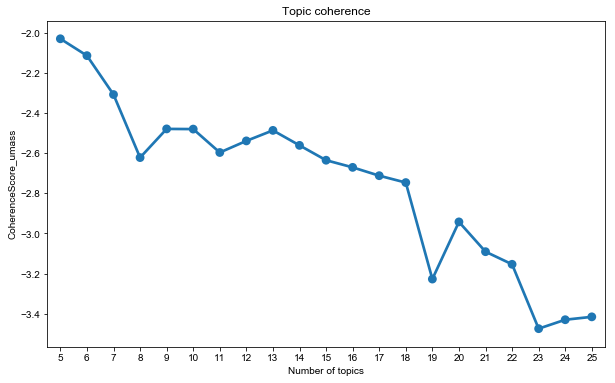

In [35]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore_umass':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore_umass',data=plotData)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

### Numbers of topics using Coherence c_v

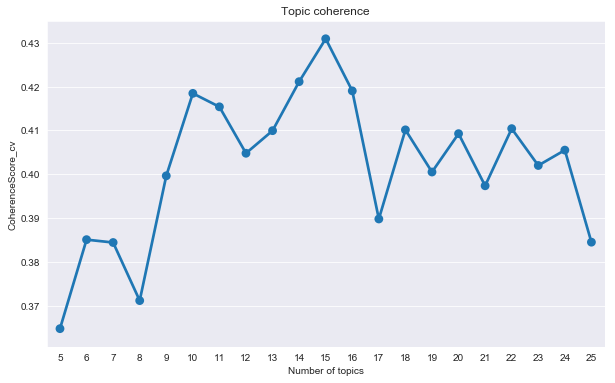

In [36]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore_cv':coherenceList_cv})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore_cv',data=plotData)
# plt.axhline(y=-3.9)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

### HDP Models

In [31]:
from gensim.models import HdpModel
hdp_model = HdpModel(corpus=doc_term_matrix,id2word=dictionary)

In [32]:
hdp_model.print_topics()

[(0,
  '0.012*like + 0.010*dog + 0.009*food + 0.009*one + 0.008*would + 0.008*taste + 0.008*good + 0.008*product + 0.007*flavor + 0.007*love'),
 (1,
  '0.013*coffee + 0.012*like + 0.010*taste + 0.009*good + 0.008*one + 0.008*flavor + 0.008*tea + 0.008*would + 0.007*product + 0.007*great'),
 (2,
  '0.012*like + 0.009*taste + 0.008*good + 0.008*one + 0.008*flavor + 0.008*product + 0.008*would + 0.007*great + 0.007*love + 0.007*food'),
 (3,
  '0.015*coffee + 0.012*like + 0.010*taste + 0.009*flavor + 0.009*good + 0.008*one + 0.007*would + 0.007*great + 0.007*product + 0.006*love'),
 (4,
  '0.010*like + 0.008*good + 0.008*taste + 0.008*great + 0.007*flavor + 0.007*coffee + 0.007*one + 0.007*product + 0.007*love + 0.006*would'),
 (5,
  '0.009*like + 0.007*good + 0.007*great + 0.007*product + 0.007*love + 0.007*taste + 0.006*one + 0.006*flavor + 0.006*coffee + 0.005*would'),
 (6,
  '0.007*chip + 0.007*like + 0.006*good + 0.006*taste + 0.006*flavor + 0.006*love + 0.006*great + 0.005*product + 

In [33]:
# Compute Coherence Score using c_v for hdp model
coherence_model_hdp = CoherenceModel(model=hdp_model, texts=data_words_bigrams, dictionary=dictionary, coherence='c_v')
coherence_hdp_c_v = coherence_model_hdp .get_coherence()
print('\nCoherence Score for HDP using c_v: ', coherence_hdp_c_v )


Coherence Score for HDP using c_v:  0.42749093464052484


In [34]:
# Compute Coherence Score using c_v for hdp model
coherence_model_hdp = CoherenceModel(model=hdp_model, texts=data_words_bigrams, dictionary=dictionary, coherence='u_mass')
coherence_hdp_u_mass = coherence_model_hdp .get_coherence()
print('\nCoherence Score for HDP using u_mass: ', coherence_hdp_u_mass )


Coherence Score for HDP using u_mass:  -8.601503842969139


### LSI Models

In [36]:
# Build the LSI model
from gensim.models import LsiModel
lsi_model = LsiModel(corpus=doc_term_matrix, num_topics=10, id2word=dictionary)


In [37]:
lsi_model.print_topics(num_topics=10,num_words=10)

[(0,
  '0.314*"like" + 0.252*"coffee" + 0.223*"taste" + 0.216*"one" + 0.199*"would" + 0.199*"good" + 0.199*"flavor" + 0.191*"food" + 0.169*"product" + 0.155*"dog"'),
 (1,
  '-0.721*"coffee" + 0.371*"dog" + 0.357*"food" + 0.179*"treat" + -0.132*"cup" + -0.119*"taste" + 0.115*"cat" + -0.112*"tea" + -0.108*"flavor" + 0.088*"product"'),
 (2,
  '-0.758*"tea" + 0.447*"coffee" + 0.267*"dog" + 0.202*"food" + 0.123*"treat" + -0.113*"flavor" + -0.101*"taste" + -0.081*"green" + 0.060*"cat" + -0.058*"sugar"'),
 (3,
  '0.549*"tea" + 0.426*"dog" + 0.313*"coffee" + -0.228*"like" + 0.212*"treat" + -0.212*"taste" + -0.199*"flavor" + -0.191*"chip" + 0.178*"food" + -0.110*"good"'),
 (4,
  '-0.649*"food" + 0.431*"treat" + -0.383*"cat" + 0.329*"dog" + -0.100*"chicken" + 0.092*"toy" + -0.089*"coffee" + -0.085*"tea" + 0.081*"one" + -0.075*"baby"'),
 (5,
  '-0.610*"like" + 0.474*"product" + -0.208*"taste" + -0.202*"dog" + 0.155*"amazon" + 0.143*"great" + -0.140*"flavor" + 0.132*"one" + -0.130*"treat" + 0.112*

In [38]:
# Compute Coherence Score for llsi model
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_words_bigrams, dictionary=dictionary, coherence='c_v')
coherence_lsi_c_v = coherence_model_lsi.get_coherence()
print('\nCoherence Score for LSI using c_v: ', coherence_lsi_c_v)


Coherence Score for LSI using c_v:  0.35284960956397293


In [39]:
# Compute Coherence Score for llsi model
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_words_bigrams, dictionary=dictionary, coherence='u_mass')
coherence_lsi_u_mass = coherence_model_lsi.get_coherence()
print('\nCoherence Score for LSI using u_mass: ', coherence_lsi_u_mass)


Coherence Score for LSI using u_mass:  -2.8777830710310117


In [47]:
from gensim.models import CoherenceModel

lda_topics = [[word for word, prob in topic] for topicid, topic in lda_model.show_topics(formatted=False)]

lsi_topics = [[word for word, prob in topic] for topicid, topic in lsi_model.show_topics(formatted=False)]

hdp_topics = [[word for word, prob in topic] for topicid, topic in hdp_model.show_topics(formatted=False)]


lsi_coherence = CoherenceModel(topics=lsi_topics, texts=data_words_bigrams, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdp_topics, texts=data_words_bigrams, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=lda_topics, texts=data_words_bigrams, dictionary=dictionary, window_size=10).get_coherence()

In [48]:
import numpy as np
def topic_model_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

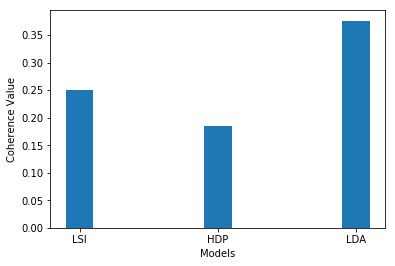

In [49]:
topic_model_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])